In [12]:
import xarray as xr
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sc
import torch
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.utils.data as data_utils
from torch.nn import Linear
from torch.functional import F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from tqdm import tqdm

import matplotlib.pyplot as plt
import csv

from itertools import combinations, permutations


In [13]:
%matplotlib inline
torch.manual_seed(21985)
np.random.seed(21985)

In [14]:
# Data from Sean's version of Hugh's Tau model
path = 'singlecatdata'
ncfile = 'offline_singlecat_referencedetail.nc'

In [15]:
ncfilepath=os.path.join(path,ncfile)

nc=xr.open_dataset(ncfilepath)

nc['ccoal'].stack(y=('altitude','case','time'))

nc

<xarray.Dataset>
Dimensions:                        (altitude: 20, case: 16, cloud_moment: 8, rain_moment: 0, time: 721)
Coordinates:
  * altitude                       (altitude) float64 0.0 100.0 ... 1.9e+03
  * time                           (time) float64 0.0 5.0 ... 3.595e+03 3.6e+03
  * cloud_moment                   (cloud_moment) int32 -6 -3 0 3 6 9 12 15
  * rain_moment                    (rain_moment) int32 
Dimensions without coordinates: case
Data variables: (12/37)
    nccn                           (case) float64 ...
    rhinit                         (case) float64 ...
    lhflux                         (case) float64 ...
    ampw                           (case) float64 ...
    tperiod                        (case) float64 ...
    pressure                       (case, altitude) float64 ...
    ...                             ...
    average_cloud_path             (case) float64 ...
    average_rain_path              (case) float64 ...
    total_precipitation_number     (case) float64 ...
    total_precipitation_amount     (case) float64 ...
    first_peak_precipitation_rate  (case) float64 ...
    first_peak_precipitation_time  (case) float64 ...

In [16]:
#define the data array
global dataArray
dataArray = np.empty(shape=(0,8))

In [17]:
def loadtaudata(process, moments_used=[0,1,2,3,4,5,6,7], dMdt_output=[0,1,2,3,4,5,6,7]):
    ### [] process is an integer that indicates which process rate we are interested in fitting
    # 0 - cond/evap, 1 - activation, 2 - collision-coalescence (self-collection), 3 - sedimentation
    # these are the order the processes are applied in the Tau model
    
    ### [] moments_used is a list of the moments that are to be trained on. i.e. [2,3,4] 
    
    proc_rates = ['cevap','act','ccoal','csed']
    #proc_rates = 'ccoal'
    env_var = ['nccn','theta','rel_hum','pressure']
    cloud_params = 'cliq_mom'
    
    ncfilepath=os.path.join(path,ncfile)
    nc=xr.open_dataset(ncfilepath)
    
    proc_rate = proc_rates[process]
    
    rates = nc[proc_rate].stack(y=('altitude','case','time'))
    corrmoments = nc[cloud_params] 
    
    cloud_moments = rates.cloud_moment
    nsamp = len(rates.y)
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #correct the moments at each time step for the processes applied in Tau up to this process is calculated 
    for i in range(0,process):
        corr_proc_rate = proc_rates[i]
        corrmoments = corrmoments - nc[corr_proc_rate]    
    
    moments = corrmoments.to_dataset(name=cloud_params).stack(y=('altitude','case','time'))

    #Compute rough scaling factors 
    
    #calculates average value of each moment for each nonzero value.
    momscale = []
    for i in range(nmoms):
        matrix = nc[cloud_params][:,moments_used[i],:,:]
        moments_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        momscale.append(moments_mean)
    #print(momscale)

    #calculates average value of dMdt for each nonzero value
    dmomscale = []
    for i in range(ndmoms):
        matrix = nc[proc_rate][:,dMdt_output[i],:,:]
        dMdt_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        dmomscale.append(dMdt_mean)
    #print(dmomscale)
    
    #hard coded values for moments [0,3,6]
    #momscale = [1e7,1e-6,1e-15]
    #dmomscale = [1e5,1e-24,1e-17]

    #normalizing procedure 
    dMdt = np.zeros((nsamp,ndmoms))
    M = np.zeros((nsamp,nmoms))
    for c in range(ndmoms):
        targetdata = rates.isel(cloud_moment=dMdt_output[c]).to_dataframe()
        #dMdt[:,c] = targetdata[proc_rate].to_numpy()/dmomscale[c]
        dMdt[:,c] = targetdata[proc_rate].to_numpy()
    for c in range(nmoms):
        momentdata = moments.isel(cloud_moment= moments_used[c]).to_dataframe()
        #M[:,c] = momentdata[cloud_params].to_numpy()/momscale[c]
        M[:,c] = momentdata[cloud_params].to_numpy()
        
    allvars = set(nc.data_vars)
    dropvars = allvars - set(env_var)
    
    nc = nc.drop_vars(dropvars)
    nc = nc.drop_dims(['rain_moment','cloud_moment'])
    
    env = nc.stack(y=('altitude','case','time'))
    env = env.to_dataframe().to_numpy()
    
    predictors = np.concatenate((M,env),axis=1)
    #predictors = M
    targets = dMdt
    
    return predictors,targets

In [18]:
class CloudDataset(Dataset):
    def __init__(self,Xdata,Ydata,device):
        self.x = Xdata
        self.y = Ydata
        self.device = device

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.x[idx,:]
        Y = self.y[idx,:]
        
        sample = {'X':torch.from_numpy(X).to(device),'Y':torch.from_numpy(Y).to(device)}

        return sample

In [19]:
class MicroEmulator(torch.nn.Module):
    def __init__(self,n_inputs=3,n_hidden=50,n_outs=3):
        super(MicroEmulator, self).__init__()
        # Just emulate everything
        
        self.dMdt = Seq(Lin(n_inputs, n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_outs))
        #self.dM0dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        #self.dM3dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        #self.dM6dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        
    def forward(self, x):
        # As inputs -- env_var = ['nccn','theta','rel_hum','pressure']
        #print(x.shape)
        #M0,M3,M6 = x[:,0],x[:,1],x[:,2]
        #Moments = [x[:,i] for i in range(8)]
        #Nccn,theta,q,p=x[:,3],x[:,4],x[:,5],x[:,6]

        #dMdt = self.dMdt(torch.stack((M0,M3,M6),dim=1))
        dMdt = self.dMdt(x)     
        #dM0dt = self.dM0dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
        #dM3dt = self.dM3dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
        #dM6dt = self.dM6dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
            
        #return torch.stack((dM0dt.squeeze(),dM3dt.squeeze(),dM6dt.squeeze()),dim=1)
        return dMdt

In [20]:
# train, test, inference
def train(model,dataloader,criterion,device, optimizer):
    model.train()
    for data in dataloader:
        X = data['X'].float()
        Y = data['Y'].float()
        #X = X.to(device)
        #Y = Y.to(device)
        out = model(X)
        loss = criterion(out,Y)
        loss.backward()
        optimizer.step()
        #sched.step()
        optimizer.zero_grad()
    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            X = data['X'].float()
            Y = data['Y'].float()
            #X = X.to(device)
            #Y = Y.to(device)
            out = model(X)
            loss = criterion(out,Y)
            correct = correct+loss

        return correct #/len(dataloader.dataset)
def inference(model,loader,device, ndmoms):
    model.eval()
    dataset = loader.dataset
    ntargets = ndmoms
    pred = np.zeros((len(dataset),ntargets))
    real = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0
    for data in enumerate(loader):
        #print(i[0],i[1]['X'].shape)

        X = data[1]['X'].float()
        Y = data[1]['Y'].float()

        #X = X.to(device)
        #Y = Y.to(device)

        out = model(X)
        #print(out.shape)
        bs = out.size(0)
        if out is not(None):
            #assert(Y.shape[0]==20),print(jj)
            #print(i,bs,Y.shape)
            real[jj:jj+bs,:]=Y.cpu().detach().numpy().reshape(bs,ntargets)
            pred[jj:jj+bs,:]=out.cpu().detach().numpy().reshape(bs,ntargets)
            jj=jj+bs
            i = i+1
        else:
            break

    return real,pred

In [21]:
def trim_data(pred, tar, moments_used, dMdt_output):
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #sets the M0 index
    try:
        idx = moments_used.index(2)
    except:
        idx = 0
        
    ###Extreme Masking of Data. Also Does Log Scaling.
    
    #to DataFrames
    df_pred = pd.DataFrame(pred)
    df_tar = pd.DataFrame(tar)

    #Mask and then Remove all datapoints with nonpositive moment values
    df_pred_mask1 = df_pred[df_pred[0:nmoms]>0].dropna()
    df_tar_mask1 = df_tar[df_pred[0:nmoms]>0].dropna()
    
    #remove all datapoints where M3 is less than 1e-2 (not considered a cloud)
    df_pred_masked = df_pred_mask1[df_pred_mask1[idx]>1e-2].dropna()
    df_tar_masked = df_tar_mask1[df_pred_mask1[idx]>1e-2].dropna()
    

    #apply log operation to both (targets are absolute-valued before logged to predict magnitude of change, not change.)
    df_pred_masked = df_pred_masked.apply(np.log10)
    df_tar_masked = df_tar_masked.apply(np.abs)
    df_tar_masked = df_tar_masked.apply(np.log10)

    #to numpy
    pred_log = df_pred_masked.to_numpy()
    tar_log = df_tar_masked.to_numpy()

    #masks and cleans too low and too high magnitudes, thresholding essentially.
    pred_log_masked = np.ma.empty(shape=pred_log.shape)
    #-2 for moment 0 is a special choice to exclude non clouds
    pred_mag_lower = [25,10,-2,-20,-30,-40,-55,-65]
    #pred_mag_upper = [40,25,8,-3,-18,-28,-40,-50]

    #masks the lower ranges of the magnitudes.
    for i in range(nmoms):
        j = moments_used[i]
        pred_log_masked[:,i] = np.ma.masked_less(pred_log[:,i],  pred_mag_lower[j])
    pred_super_masked = np.ma.mask_rows(pred_log_masked)
    pred_super_mask = np.ma.getmaskarray(pred_super_masked)
    pred_super_comp = pred_super_masked.compressed()
    final_pred_log = np.reshape(pred_super_comp, (pred_super_comp.size//nmoms,nmoms))

    #converts targets to be filtered as well, and then logged.
    new_tar_masked = np.ma.asarray(tar_log)
    new_tar_masked.mask = pred_super_mask
    new_tar_comp = new_tar_masked.compressed()
    final_tar_log = np.reshape(new_tar_comp,(new_tar_comp.size//nmoms,nmoms))


    #lower roundoff
    tar_mag_lower = [10, 0, -10, -38, -42, -55, -70, -90]
    for i in range(nmoms):
        final_tar_log[:,i] = np.nan_to_num(final_tar_log[:,i],neginf=tar_mag_lower[moments_used[i]])

    #Scales predictor values to between 0 and 1
    scaler_pred = preprocessing.MinMaxScaler()
    final_pred_log = scaler_pred.fit_transform(final_pred_log)

    #Scales target values to between 0 and 1
    scaler_tar = preprocessing.MinMaxScaler()
    final_tar_log = scaler_tar.fit_transform(final_tar_log)
    
    #renaming
    tarrescaled = final_tar_log
    predrescaled = final_pred_log
    
    return predrescaled, tarrescaled, scaler_pred, scaler_tar

In [22]:
#array index values:
# 0, 1, 2, 3, 4, 5, 6, 7
#actual moments:
#-6,-3, 0, 3, 6, 9,12,15

### Change this list as needed for the run ###

def make_prediction(moments_used, device="cpu"):
    #setting outputs to be same numbers as inputs
    dMdt_output = moments_used
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #load tau data
    #2 since we are interested in self-collection/collision-coalescence
    pred,tar = loadtaudata(2,moments_used,dMdt_output)
    
    predrescaled, tarrescaled, scaler_pred, scaler_tar = trim_data(pred, tar, moments_used, dMdt_output)
    
    # Split into test, train, val
    idx = np.arange(0,predrescaled.shape[0])
    selidx = idx #np.random.choice(idx,size=50000)

    X_train, X_test, y_train, y_test = train_test_split(predrescaled[selidx,:],tarrescaled[selidx,:],test_size = 0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.25, random_state=42)
    #print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

    traindataset = CloudDataset(X_train,y_train,device)
    valdataset = CloudDataset(X_val,y_val,device)
    testdataset = CloudDataset(X_test,y_test,device)

    # Check if there is a gpu
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = "cpu"
    #print(device)

    #collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)) ???
    trainloader = DataLoader(traindataset,batch_size=20,shuffle=True,num_workers=0)
    valloader = DataLoader(valdataset,batch_size=20,shuffle=True,num_workers=0)
    testloader = DataLoader(testdataset,batch_size=20,shuffle=True,num_workers=0)

    # Instantiate the neural network
    model = MicroEmulator(n_inputs=nmoms, n_outs=ndmoms)
    
    #lr = 1e-4 initially
    init_lr = 1e-3
    weight_decay = 1e-8
    total_epochs = 100

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    #print(model)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    val_accur = []
    train_accur = []
    
    for epoch in tqdm(range(0,total_epochs)):
        model = train(model,trainloader,criterion,device, optimizer)
        train_acc = test(model,trainloader,criterion,device)
        val_acc = test(model,valloader,criterion,device)
        val_accur.append(val_acc)
        train_accur.append(train_acc)
        #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.8f}, Val. Acc: {val_acc:.8f}')

    
    # plt.figure(figsize=(10, 6))
    # plt.plot(train_accur)
    # plt.plot(val_accur)
    # plt.yscale('log')
    # plt.ylabel("Loss", fontsize=20)
    # plt.xlabel("Epochs", fontsize=20)
    # plt.close()
    
    trainreal,trainpred=inference(model,trainloader,device, ndmoms)
    valreal,valpred=inference(model,valloader,device, ndmoms)
    testreal,testpred=inference(model,testloader,device, ndmoms)

    print(str(3*np.array(moments_used)-6))
#      for i in range(testreal.shape[1]):
#         print(str(3*moments_used[i]-6))
#         print(str(mean_squared_error(testreal[:,i],testpred[:,i])))
#         print(str(mean_absolute_error(testreal[:,i],testpred[:,i])) + "\n")
    
    #writes a row of data to the .csv file
    moments = [str(3*moments_used[i]-6) for i in range(testreal.shape[1])]
    testreal = np.nan_to_num(testreal)
    testpred = np.nan_to_num(testpred)
    MSE_data = [str(mean_squared_error(testreal[:,i],testpred[:,i])) for i in range(testreal.shape[1])]
    row = moments + MSE_data
    global dataArray
    dataArray = np.vstack((dataArray,np.array(row)))

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
    plt.subplots_adjust(hspace=0.4)
    for i in range(ndmoms):
        ax0 = axs[int(i/4),int(i%4)]
        ax0.set_title('dM'+str(3*dMdt_output[i]-6) +'dt')
        ax0.scatter(trainreal[:,i],trainpred[:,i],s=3,label='Train')
        ax0.scatter(testreal[:,i],testpred[:,i],s=3,label='Test')
        ax0.set_xlabel("True")
        ax0.set_ylabel("Predicted")
        ax0.set_xlim(0,1.1)
        ax0.set_ylim(0,1.1)
        ax0.legend()




#     fig.suptitle('Single Category NN Regression')
#     phrase = ""
#     for i in moments_used:
#         phrase = phrase + str(3*i-6)
#         phrase = phrase + "_"
#     plt.savefig("SingCatRegression_M" + phrase + ".png")
#     plt.close()
    
    return model

In [23]:
#################################
###NEURAL NETWORK TRAINING CELL
#
#  RUN THIS TO START TRAINING
#################################


#uses GPU if available, cpu if not.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#the GPU is currently slower than CPU when I try using it
#device = "cpu"


#assumes 4 moment scheme.
header = ["Moment 1", "Moment 2", "Moment 3", "Moment 4", "Value 1", "Value 2", "Value 3", "Value 4"]

######################
###TESTING ALL MOMENTS
######################

# possible_inputs = [0,1,2,3,4,5,6,7]
# combos = combinations(possible_inputs,4)
# for i in list(combos):
#     arr = list(i)
#     print(3*np.array(list(arr))-6)
#     mod, scaler_tar, scaler_pred = make_prediction(moments_used=list(arr), device=device)
#     Mstring = '-'.join([str(3*x-6) for x in arr])
#     modelfile = Mstring+'_model.pth'
#     torch.save(mod, modelfile)

#######################
###SINGLE SCHEME SCRIPT
#######################

arr = [2,3,4,5] #Moments 0,3,6,9
mod = make_prediction(moments_used=list(arr), device=device)
Mstring = '-'.join([str(3*x-6) for x in arr])
modelfile = Mstring+'_model.pth'
torch.save(mod, modelfile)
   

### Writes to .csv file

# with open('4-moment-MSE.csv', "w", newline='') as csvfile:
#     writer = csv.writer(csvfile, delimiter=",")
#     writer.writerow(header)
#     writer.writerows(dataArray.tolist())

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by MinMaxScaler.

In [187]:
###TESTING

moments_used=[2,3,4,5]
dMdt_output=[2,3,4,5]
#M and dMdt

#Scale everything to be between 0 and 1
pred,tar = loadtaudata(2,moments_used,dMdt_output)

#Mask and then Remove all datapoints with nonpositive values
pred_masked = np.ma.mask_rows(np.ma.masked_less_equal(pred,0))
pred_mask = np.ma.getmaskarray(pred_masked)
pred_comp = pred_masked.compressed()
new_pred = np.reshape(pred_comp, (pred_comp.size//4, 4))

tar_masked = np.ma.asarray(tar)
tar_masked.mask = pred_mask
tar_comp = tar_masked.compressed()
new_tar = np.reshape(tar_comp,(tar_comp.size//4, 4))

print(new_pred.shape)
print(new_tar.shape)

pred_log = np.log10(new_pred)
tar_log = np.log10(new_tar)

scaler_tar = preprocessing.MinMaxScaler()
tarrescaled = scaler_tar.fit_transform(tar)
scaler_pred = preprocessing.MinMaxScaler()
predrescaled = scaler_pred.fit_transform(pred)


print((pred[:,3]<0).sum())


###Each Moment needs to be scaled differently
tar_cutoffs = [6e-1,4e-1,1e-15,5e-15]
for i in range(4):
    tarrescaled_mask[:,i] = np.ma.masked_outside(tarrescaled[:,i],tar_cutoffs[i],1)

###Mask Pred
#2,3,4,5 cutoffs chosen semi arbitrarily
pred_cutoffs = [6e-6,1e-6,1e-15,1e-20]
for i in range(4):
    predrescaled_mask[:,i] = np.ma.masked_outside(predrescaled[:,i],pred_cutoffs[i],1)

print('dMdt mask count: ' + str(np.ma.count_masked(tarrescaled_mask,axis=0)))
print('M mask count: ' + str(np.ma.count_masked(predrescaled_mask,axis=0)))


tarrescaled_log10 = np.log10(tarrescaled_mask)
predrescaled_log10 = np.log10(predrescaled_mask)

print(pred.shape)
# fig,axs = plt.subplots(4,4,figsize=(16,16))
# for i in range(4):
#     #print('Tar ' + str(np.amin(tarrescaled_log10[:,i])))
#     axs[0,i].plot(np.arange(0,pred.shape[0],1), pred[:,i])
#     axs[1,i].plot(np.arange(0,tar.shape[0],1), predrescaled[:,i])
#     axs[2,i].plot(np.arange(0,tar.shape[0],1), predrescaled_mask[:,i])
#     axs[3,i].plot(np.arange(0,pred.shape[0],1), predrescaled_log10[:,i])

# fig.suptitle('Moments 0-3-6-9 Data display')
# #plt.show()


(206875, 4)
(206875, 4)
168
dMdt mask count: [ 1146  1160 77926 98530]
M mask count: [74290 64277 30249 30128]
(230720, 4)


/burg/glab/users/raa2218/envs/geo_scipy_torch/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/burg/glab/users/raa2218/envs/geo_scipy_torch/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


(174271, 8)
(174271, 8)


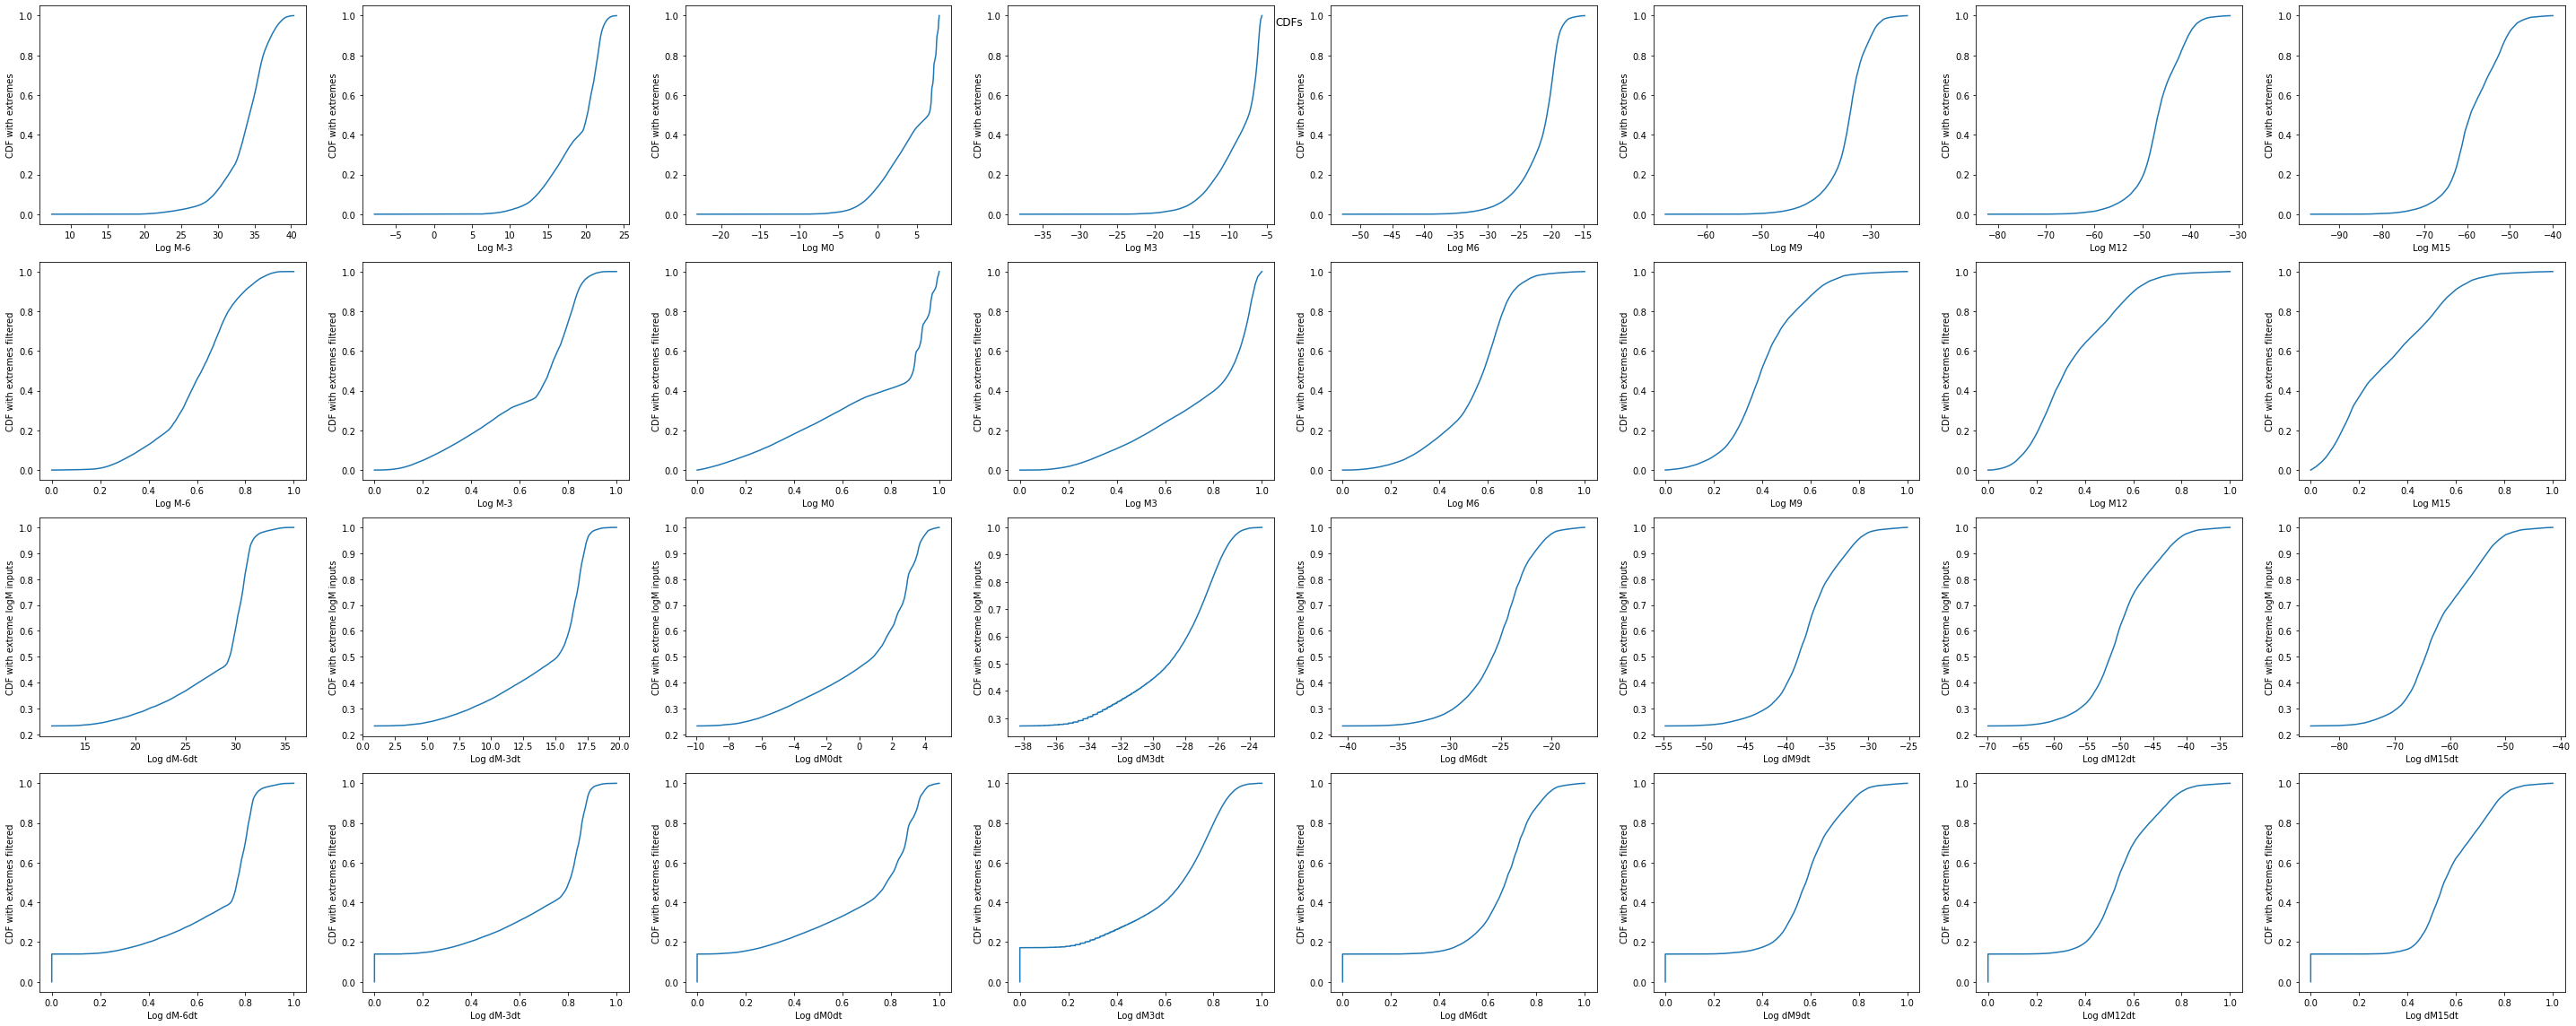

In [39]:
###TESTING 2

#1. Mask nonpositive, 2. Log, 3. Scale to between 0 and 1

moments_used=[0,1,2,3,4,5,6,7]
dMdt_output=moments_used

nmoms = len(moments_used)
#M and dMdt

pred,tar = loadtaudata(2,moments_used,dMdt_output)

#convert to DataFrames
df_pred = pd.DataFrame(pred)
df_tar = pd.DataFrame(tar)

#Mask and then Remove all datapoints with nonpositive values
df_pred_masked = df_pred[df_pred>0].dropna()
df_tar_masked = df_tar[df_pred>0].dropna()

#apply log operation to both (targets are absolute-valued before logged to predict magnitude of change, not change.)
df_pred_masked = df_pred_masked.apply(np.log10)
df_tar_masked = df_tar_masked.apply(np.abs)
df_tar_masked = df_tar_masked.apply(np.log10)

#to numpy
pred_log = df_pred_masked.to_numpy()
tar_log = df_tar_masked.to_numpy()

#masks and cleans too low and too high magnitudes, thresholding essentially.
pred_log_masked = np.ma.empty(shape=pred_log.shape)
#-2 for moment 0 is a special choice to exclude non clouds
pred_mag_lower = [25,10,-2,-20,-30,-40,-55,-65]
#pred_mag_upper = [40,25,8,-3,-18,-28,-40,-50]

#masks the lower ranges of the magnitudes.
for i in range(nmoms):
    j = moments_used[i]
    pred_log_masked[:,i] = np.ma.masked_less(pred_log[:,i],  pred_mag_lower[j])
pred_super_masked = np.ma.mask_rows(pred_log_masked)
pred_super_mask = np.ma.getmaskarray(pred_super_masked)
pred_super_comp = pred_super_masked.compressed()
final_pred_log = np.reshape(pred_super_comp, (pred_super_comp.size//nmoms,nmoms))

#converts targets to be filtered as well, and then logged.
new_tar_masked = np.ma.asarray(tar_log)
new_tar_masked.mask = pred_super_mask
new_tar_comp = new_tar_masked.compressed()
final_tar_log = np.reshape(new_tar_comp,(new_tar_comp.size//nmoms,nmoms))


#lower roundoff
tar_mag_lower = [10, 0, -10, -38, -42, -55, -70, -90]
for i in range(nmoms):
    final_tar_log[:,i] = np.nan_to_num(final_tar_log[:,i],neginf=tar_mag_lower[moments_used[i]])

#Scales predictor values to between 0 and 1
scaler_pred = preprocessing.MinMaxScaler()
final_pred_log = scaler_pred.fit_transform(final_pred_log)
    
#Scales target values to between 0 and 1
scaler_tar = preprocessing.MinMaxScaler()
final_tar_log = scaler_tar.fit_transform(final_tar_log)

print(final_pred_log.shape)
print(final_tar_log.shape)



fig,axs = plt.subplots(4,nmoms,figsize=(40,16))
x  = np.arange(0,pred_log.shape[0],1)/pred_log.shape[0]
x_reduced = np.arange(0,final_tar_log.shape[0],1)/final_tar_log.shape[0]
for i in range(nmoms):
    axs[0,i].plot(np.sort(pred_log[:,i],axis=0),x)
    axs[0,i].set_xlabel('Log M' + str(3*moments_used[i]-6))
    axs[0,i].set_ylabel('CDF with extremes')
    
    axs[1,i].plot(np.sort(final_pred_log[:,i],axis=0),x_reduced)
    axs[1,i].set_xlabel('Log M' + str(3*moments_used[i]-6))
    axs[1,i].set_ylabel('CDF with extremes filtered')
    
    axs[2,i].plot(np.sort(tar_log[:,i],axis=0),x)
    axs[2,i].set_ylabel('CDF with extreme logM inputs')
    axs[2,i].set_xlabel('Log dM' + str(3*moments_used[i]-6)+'dt')
    
    axs[3,i].plot(np.sort(final_tar_log[:,i],axis=0),x_reduced)
    axs[3,i].set_xlabel('Log dM' + str(3*moments_used[i]-6)+'dt')
    axs[3,i].set_ylabel('CDF with extremes filtered')

fig.tight_layout()
fig.set_facecolor(color="white")
fig.suptitle('CDFs')
#plt.savefig("CDFlogplot")
plt.show()


In [14]:
#read in the data in the csv file for 4 moments into performance matrix

file = open('4-moment-MSE.csv')
csvreader = csv.reader(file)
header = next(csvreader)

#data structure used for plotting the data
performance = np.zeros(shape=(8,8,8,8))

#select whether the rows come directly from the just generated dataArray or from an external file
#rows = csvreader
rows = dataArray.tolist()

for row in rows:
    #print(row)
    perms = permutations([0,1,2,3])
    for perm in list(perms):
        perm = list(perm)
        indices = [int(row[perm[i]])//3+2 for i in range(4)]
        performance[indices[0],indices[1],indices[2],indices[3]] = float(row[perm[0]+4])

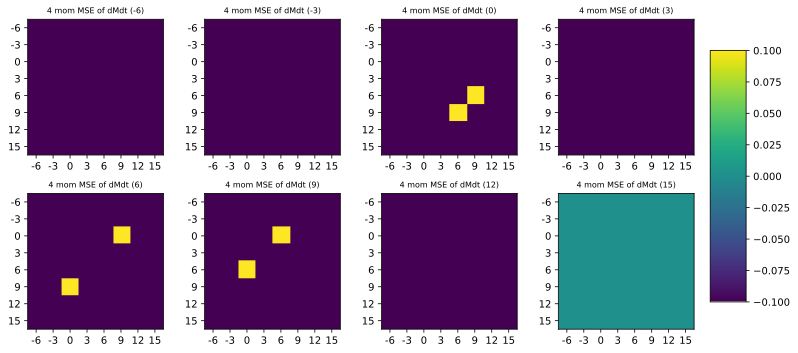

In [15]:
#Plots Performance

#currently uses moment 3 as the fixed moment, plots over the other moments

fig,axs = plt.subplots(2,4,figsize=(10,5))
for mmt0 in range(2):
    for mmt in range(4):
        data = performance[3,mmt0*4+mmt]
        axs[mmt0,mmt].set_xticks(ticks=np.arange(0,8), labels=np.arange(-6,16,3))
        axs[mmt0,mmt].set_yticks(ticks=np.arange(0,8), labels=np.arange(-6,16,3))
        im = axs[mmt0,mmt].imshow(data, interpolation='nearest')

        # for i in range(8):
        #     for j in range(8):
        #         text = ax.text(j, i, data[i, j],
        #                        ha="center", va="center", color="w")

        axs[mmt0,mmt].set_title("4 mom MSE of dMdt (" +str( (mmt0*4+mmt)*3-6 ) + ")")
        axs[mmt0,mmt].title.set_fontsize(8)
        #plt.colorbar(im)
        #plt.savefig("4_mom_MSE_dMdt_" +str(3*mmt) +".png")
fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()
#plt.savefig("4_moments_MSE_mom3.png")